# Customer review timeline (of Sea Temple Port Douglas)

## TLDR:

I explore the current trends of `customer experience` through online comments on TripAdvisor for Pullman Sea temple (PPD) in Port Douglas, Queensland, Australia.

By analysing the scores, I discovered:
- The [score distribution by comments](#how-scores-distribute). Most comments have a high score (5 bubbles/stars)!

However, when applying a `Time series analysis` I realised that:
- [Monthly average number of comments](#timeseries) has increased through the years, although
- [Score evolution](#score-through-time) shows a declining trend in recient years, and
- when counting the proportion of comments, I dicovered that despite most comments are still positive, negatives are growing

To undertand the customer experience and why the score are declining, I performed several `Text analysis` of the actual comments, to discover:
- By using multiple strategies I extrated [most common phases](#the-comments) to see which factors are the most important for customers, like the swimming pool, the distance to town or the staff
- Applying `vector similarity`, I build a [semi-supervised sentence classifier](#semi-supervised-classification-of-text) to group the text by its content in 5 categories: Housekeeping, Infrastructure, Restaurant, Front Desk and other. I later checked if their prevalence changed through time. Which wasn't the case.
- Also, I used full unsupervised [Topic modelling technique](#other-way-to-classify-reviews-lda) to explore more relevant topics I could miss in the first analysis.
- Then, I applied [Sentiment Analysis](#sentiment-analysis), to score how positive or negative a comment was by its content, and realised that Housekeeping has the most negative sentiment because it was higly impacted by high demand periods. 
- Finally, I validated the result with the associated score to the sentence.


---
## Context

I'm travelling throughout Australia with a WH visa. I wanted to apply for an extension of my visa. Then, to do so, I have to work either in hospitality or farm for 88 days north of the tropic. I have experience in both farms (picking fruit in New Zealand in a WH as well) and tourism (in Chile as [data] consultant), but this is not New Zealand, here there are lots of deadly animals everywhere. I’d rather work inside a Resort than in the countryside. So, I moved to Port Douglas, a very touristic hot spot.

The work is nice as a housekeeper, but I miss my analytics. Of course, before I came, I wanted to know "who is who" in this touristic hub in northern Queensland, which is close to the Daintree rainforest and one of the best spots to see the giant coral reef. 

I knew the major players and I checked their commentaries on TripAdvisor. Later, talking to one of the supervisors about customer reviews, I was taught the metrics of quality they hold. It seems none of the metrics considered the text -which is my specialization- to build a systematic review through time (I mean, they read  thoughtfully and have some insights how comments vary through time, but not a systematic indicator, let say a number over text or some other pattern).

I think it is time to apply some analytics to text review the TripAdvisor reviews. I updated my webscraping script to get the data (1880 English reviews) and is time to  play.

## Load and data pre-view

In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib as plt
plt.rcParams["figure.figsize"] = [15, 7]
import scipy.stats as stats
from __future__ import unicode_literals
plt.style.use(['dark_background'])

In [2]:
data = pd.read_csv('./tripullman/test.csv', encoding= "utf-8")
print(data.shape)
# Let's use english names in columns for clarity
data.columns = ['n_opinions', 'level', 'about', 'author','score', 'about_score', 'comment', 'address', 'date', 
'location','name', 'region', 'type','type1', 'title', 'link']

(1880, 16)


In [3]:
data.head(3)

,n_opinions,level,about,author,score,about_score,comment,address,date,location,name,region,type,type1,title,link
0,"1,915 reviews",6,Pullman Port Douglas Sea Temple Resort & Spa,Neil O,30,4.5,5 star prices and 3 star service. We stayed in...,"Mitre St,Port Douglas, Queensland 4877, ,Austr...",14 September 2018,NaN,Pullman Port Douglas Sea Temple Resort & Spa,Queensland,Hotel,"of 42 , of 42",First family holiday,https://www.tripadvisor.com.au/Hotel_Review-g2...
1,"1,915 reviews",7,Pullman Port Douglas Sea Temple Resort & Spa,Daniel L,50,4.5,We have stayed now 2 times. The staff have alw...,"Mitre St,Port Douglas, Queensland 4877, ,Austr...",2 September 2018,NaN,Pullman Port Douglas Sea Temple Resort & Spa,Queensland,Hotel,"of 42 , of 42",The best hotel in port Douglas,https://www.tripadvisor.com.au/Hotel_Review-g2...
2,"1,915 reviews",1,Pullman Port Douglas Sea Temple Resort & Spa,Carrie G,20,4.5,My family and I recently stayed for 5 nights a...,"Mitre St,Port Douglas, Queensland 4877, ,Austr...",5 September 2018,NaN,Pullman Port Douglas Sea Temple Resort & Spa,Queensland,Hotel,"of 42 , of 42",Not deserving of 5 star rating,https://www.tripadvisor.com.au/Hotel_Review-g2...


In [4]:
# tidy calification scores
data.score = data.score/10

## How scores distribute

TripAdvisor has a system of bubbles (or Stars) ranking from 1 to 5. In that respect, most reviews give 5 bubbles to the resort with more than 1000 high score reviews (more than half of reviews).

In [5]:
data.score.describe()

count    1880.000000
mean        4.261170
std         0.986002
min         1.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: score, dtype: float64

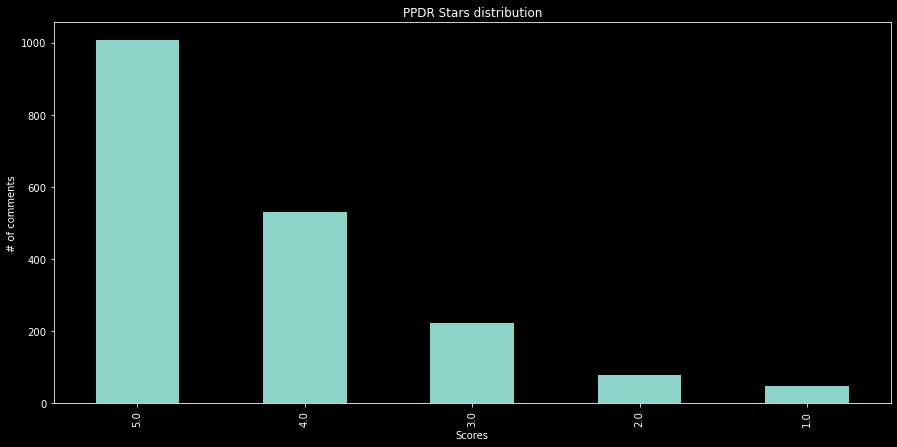

In [76]:
data.score.value_counts().plot(kind='bar', title='PPDR Stars distribution', ylabel='# of comments', xlabel='Scores');

## Timeseries
 
First, let's see how many commentaries the resort has monthly.

In [7]:
data['date2'] = pd.to_datetime(data.date, format='%d %B %Y')
dfd = data.copy()
dfd.set_index(pd.DatetimeIndex(dfd['date2']), inplace=True)
dfd = dfd.sort_index()

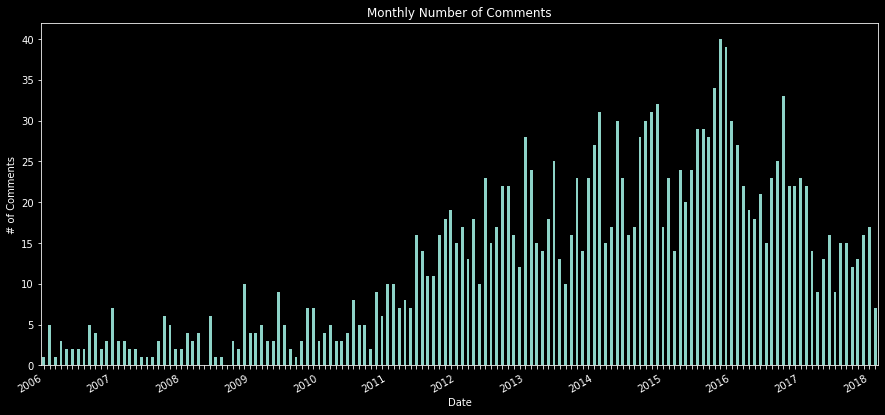

In [8]:
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

bar_chart = dfd.score.copy()
bar_chart = bar_chart.resample(rule='M').count()
ax = bar_chart.plot(kind='bar', x = bar_chart.index)

# Make most of the ticklabels empty so the labels don't get too crowded
ticklabels = [''] * len(bar_chart.index)
# Every 12th ticklabel includes the year
ticklabels[::12] = [item.strftime('%Y') for item in bar_chart.index[::12]]
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
ax.set_title('Monthly Number of Comments')
ax.set_ylabel('# of Comments')
ax.set_xlabel('Date')
plt.pyplot.gcf().autofmt_xdate()
plt.pyplot.show()

OK. So since 2012 comments are 20 each month, reaching a pick in 2017 up to 40 comments in a single month.

### Score through time

Let's calculate the score average for every month.

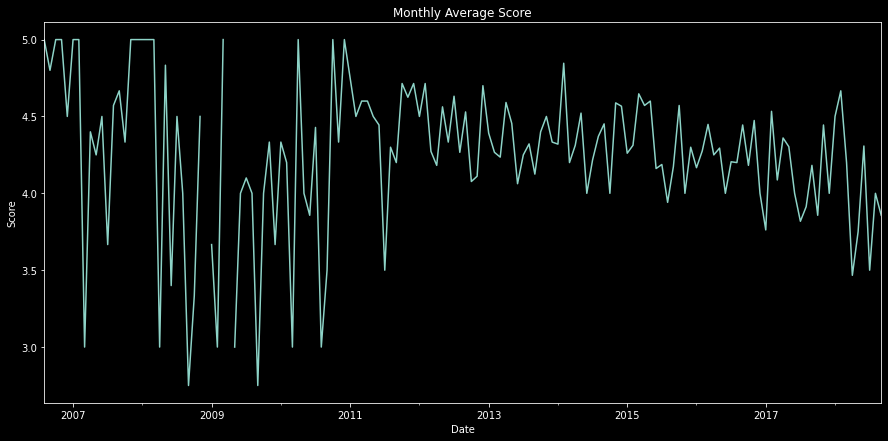

In [77]:
linear = dfd.score.copy()
linear = linear.resample(rule='M').mean()
linear.plot(kind='line', title='Monthly Average Score', ylabel='Score', xlabel='Date');

It seems that before 2012 -when there is few comments- the mean is quite volatile, but then moves aroud 4.5 and its been slighly decreasing. More stable number could be the accumulate version.

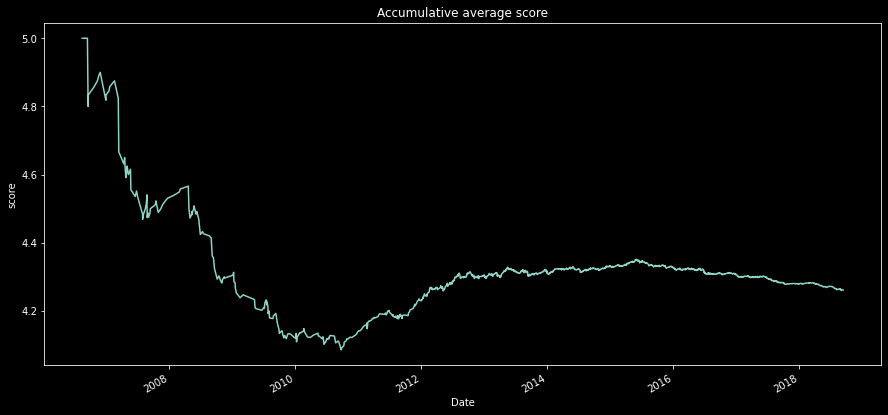

In [78]:
dfd.score.expanding().mean().plot(title='Accumulative average score', ylabel='score', xlabel='Date');

The mean becomes more stable as more reviews are added, therefore, to change a reputation over time requires a lot of comments of the opposite sign. It means that the initial good reputation was easily lowered at the beginning by a few bad comments but then reverse easily as well. But then, when it reaches a plateau, change is more subtle. So, the slight decrease, in the end, could be hiding something.

Let's see the distribution of reviews over time if we normalize the number of reviews. Just take data from 2014 and on to take the initial noise out.

C:\Users\framo\AppData\Local\Temp/ipykernel_21284/3558637368.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  calification = calification.drop('total', 1) #erase total column


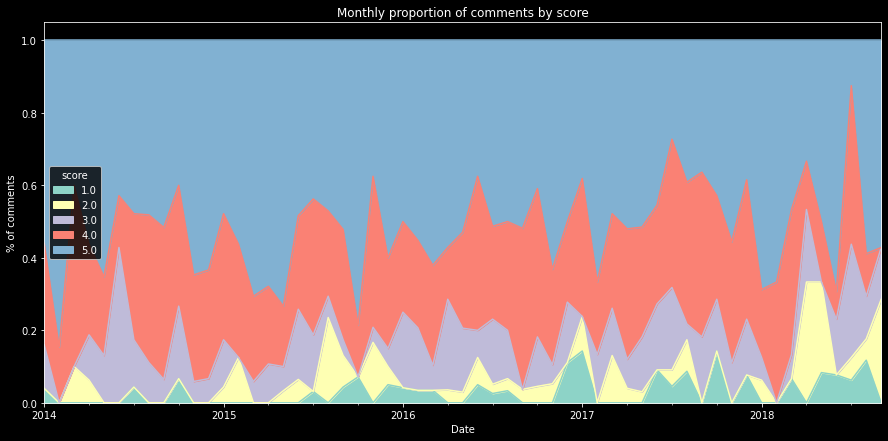

In [79]:
calification = pd.crosstab(dfd.date2, dfd.score)
calification = calification.resample(rule='M').sum()
calification['total'] = calification.sum(axis=1) # calculate a horizontal sum as total
calification = calification.div(calification.total, 0) # divide each column again total column
calification = calification.drop('total', 1) #erase total column

calification.loc['2014':,:].plot(kind='area', ylabel="% of comments", xlabel='Date', title= "Monthly proportion of comments by score");
#calification.head()

It seems that the last year scores lower than 3 are more common than before. What if we compare year after year.

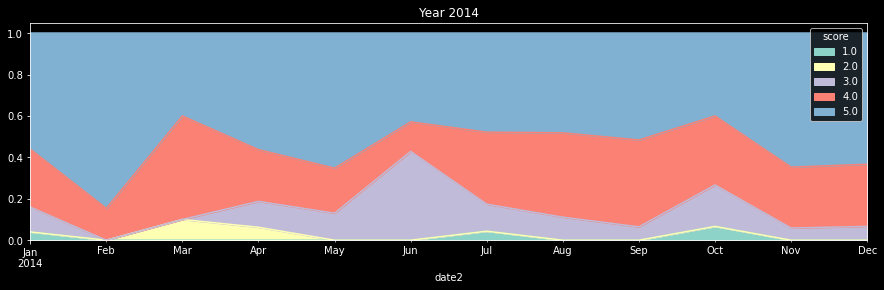

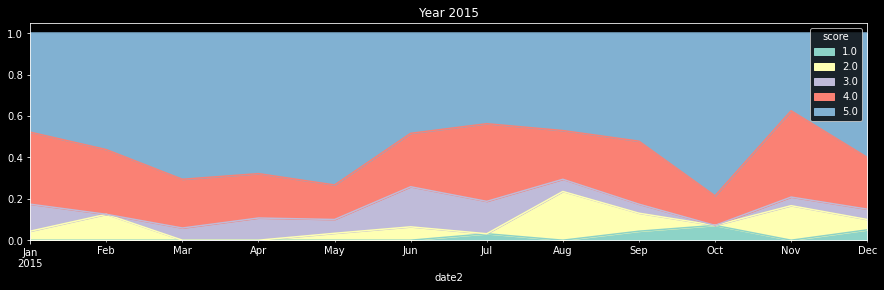

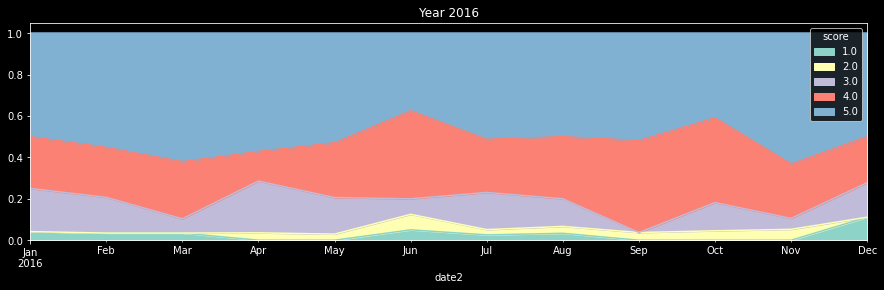

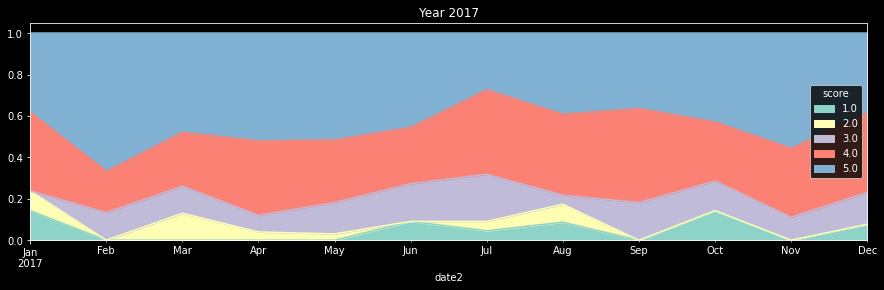

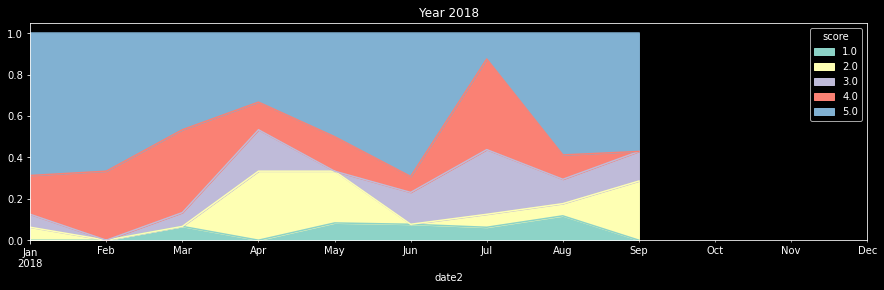

In [80]:
years = map(str, calification.index.year.unique()[8:].tolist())
years = [*years]
for year, i in zip(years[:-1], range(len(years)-1)):
    calification.loc[year:year,:].plot(kind='area',figsize=(15,4),sharex=True, title="Year {}".format(year))
calification.loc['2018':'2018',:].plot(kind='area',figsize=(15,4),xlim=(pd.Timestamp('2018-01-31 00:00:00', tz=None),
pd.Timestamp('2018-12-01 00:00:00', tz=None)), title="Year {}".format('2018'));

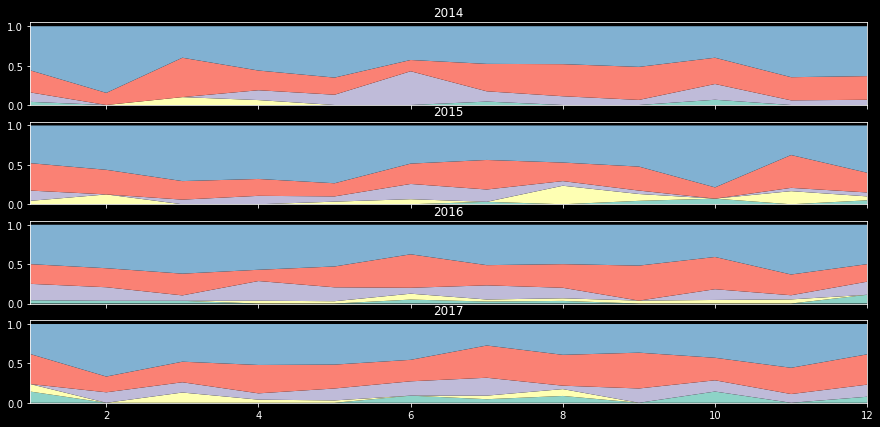

In [13]:
# Just for practice. Can I put all years in a single multi-plot?
from matplotlib import dates
fig, ax = plt.pyplot.subplots(4, 1, sharex='col', sharey='row')
years = map(str, calification.index.year.unique()[8:].tolist())
years = [*years]
x_dates = calification.index.month.sort_values().unique()
for year, i in zip(years[:-1], range(len(years)-1)):
    c=calification.loc[year:year,:]
    ax[i].stackplot(c.index.month,c[c.columns[0]],c[c.columns[1]],c[c.columns[2]],c[c.columns[3]],c[c.columns[4]])
    ax[i].set_xlim(1,12)
    ax[i].set_title(year)
    

In the last year there are more negatives comments. Something not good is happening.

## The Comments

Despite previous observations, many reviews are generally positive, but they refer to different things. To make things clearer let's split the reviews into sentences. That way we could note the difference if a comment is about more than one subject.

### Prepare text data and split reviews into sentences

In [14]:
from nltk.tokenize import word_tokenize, sent_tokenize

data_sentence = data[['title','score','comment','date']].copy()
data_sentence.dropna(subset = ['comment'], inplace=True)
data_sentence['sentence'] = data_sentence.comment.apply(sent_tokenize)
data_sentence = (data_sentence['sentence'].apply(lambda x: pd.Series(x)).stack().reset_index(level=1, drop=True).to_frame('sentence').join(data_sentence[['title','score','comment','date']], how='left'))

Check the new data set with a sentence by row.

In [15]:
data_sentence.reset_index(drop=True, inplace=True)
data_sentence.head()

,sentence,title,score,comment,date
0,5 star prices and 3 star service.,First family holiday,3.0,5 star prices and 3 star service. We stayed in...,14 September 2018
1,We stayed in a villa with a private pool which...,First family holiday,3.0,5 star prices and 3 star service. We stayed in...,14 September 2018
2,The maintenance man even said it’s so hard to ...,First family holiday,3.0,5 star prices and 3 star service. We stayed in...,14 September 2018
3,The food is bang average not just at the hotel...,First family holiday,3.0,5 star prices and 3 star service. We stayed in...,14 September 2018
4,The staff are all great and try and make your ...,First family holiday,3.0,5 star prices and 3 star service. We stayed in...,14 September 2018


## Look for meaning (most significative bi-grams)

#### Extract most common bi-grams and tri-grams

To explore the content first I could have a look of the most frequent words. A simple model of sklearn can give us that information. Let’s see some bi-grams and tri-grams.

In [16]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

stp = nltk.corpus.stopwords.words('English') 
data_sentence.sentence.dropna(inplace=True)

vectorizer = TfidfVectorizer(lowercase=True, stop_words=stp[:130] ,ngram_range = (2,3), min_df=5).fit(data_sentence.sentence)
full_matrix = vectorizer.transform(data_sentence.sentence)


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 're', 've'] not in stop_words.
  warnings.warn(


In [17]:
def display_scores(vectorizer, tfidf_result,n=50):
    # http://stackoverflow.com/questions/16078015/
    scores = zip(vectorizer.get_feature_names_out(),
                 np.asarray(tfidf_result.sum(axis=0)).ravel())
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    for item in sorted_scores[:n]:
        print("{0:50} Score: {1}".format(item[0], item[1]))
        
display_scores(vectorizer,full_matrix,25)

sea temple                                         Score: 189.90169447722204
port douglas                                       Score: 182.21243902619142
pool bar                                           Score: 69.29847448091986
staff friendly                                     Score: 65.5138027376518
stayed nights                                      Score: 51.820851519108004
room service                                       Score: 51.07599969858622
pool area                                          Score: 48.87967481590824
lagoon pool                                        Score: 44.75179774602524
front desk                                         Score: 43.37761076592198
golf course                                        Score: 42.37498411886369
plunge pool                                        Score: 41.55567496675205
friendly helpful                                   Score: 38.634722321888624
two bedroom                                        Score: 36.10181404189697
swimming 

This is the most frequent combination of words in the reviews. It doesn't seem to be very meaningful. But we can collect some insights. So, besides the name of the resort, the pool and the staff are definitely the most common words (and let me tell you, the pool is upstanding), and must be a very important part of the customer experience. Let's try another technique to get more information.

### Detect keyphases

We can improve the detection of n-grams. It not only will help to create keyphases to identify the text but also will improve the understanding of the text itself.

##### Keyphrases with bigrams

In [18]:
import nltk
import gensim
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.utils import simple_preprocess
from collections import Counter

data_words = [i for i in data_sentence.sentence]
#data_words = data_sentence.sentence.apply(word_tokenize)
data_words = [simple_preprocess(i, deacc=True) for i in data_words]
# Build the bigram and trigram models
bigram = Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)


Now we check how one sentence looks once we created the n-grams.

In [19]:
print(trigram_mod[bigram_mod[data_words[632]]])

['me', 'and', 'my', 'husband', 'visited', 'port_douglas', 'for', 'short', 'stay', 'and', 'booked', 'an', 'accomodation', 'at', 'pullman', 'sea_temple', 'port_douglas']


Seems to work. Now I can clean the sentences and apply the ngram model it to the whole corpus.

In [20]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stp] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

text = remove_stopwords(data_words)
text = make_bigrams(text)
text = make_trigrams(text)

In [21]:
# Let's replace the sentences with the trigams and bigrams
data_sentence.sentence = text
data_sentence.sentence = data_sentence.sentence.apply(' '.join)

People are astonished by the direct access to the pool. As we see previously the pool is one of the most common words in reviews. It is quite an impressive pool. I would bet is the main selling factor. Since we have some "new words" created on n-grams let’s try to check if I can create some keyphrases. For that, I will use word2Vec or word embeddings, that in theory would help to find synonymous to those phrases.

In [22]:
from gensim.models import Word2Vec

bigram_model = Word2Vec(bigram_mod[data_words])
bigram_model_counter = Counter()
for key in bigram_model.wv.vocab.keys():
    if key not in stp:
        if len(key.split("_")) > 1:
            bigram_model_counter[key] += bigram_model.wv.vocab[key].count

In [23]:
for key, counts in bigram_model_counter.most_common(30):
    print('{0} \t {1}'.format(key.encode("utf-8"), counts))

b'sea_temple' 	 523
b'port_douglas' 	 512
b'front_desk' 	 74
b'golf_course' 	 67
b'highly_recommend' 	 56
b'roof_top' 	 56
b'shuttle_bus' 	 52
b'well_appointed' 	 47
b'hot_tub' 	 40
b'direct_access' 	 35
b'ground_floor' 	 34
b'barrier_reef' 	 30
b'mile_beach' 	 29
b'school_holidays' 	 29
b'wedding_anniversary' 	 28
b'palm_cove' 	 26
b'five_star' 	 26
b'hire_car' 	 25
b'minute_drive' 	 24
b'four_mile' 	 23
b'ended_up' 	 22
b'washer_dryer' 	 21
b'spiral_staircase' 	 21
b'main_street' 	 20
b've_ever' 	 20
b'young_children' 	 19
b'per_person' 	 19
b'make_sure' 	 19
b'self_contained' 	 18
b'washing_machine' 	 18


Now it looks like we can found some meaning on them. Let's check some interesting ones within context. Because we are only focusing in a sentence within a whole text, let's highlight the sentence words in red.

In [24]:
pd.set_option('display.max_colwidth', None)

from IPython.display import display, Markdown, Latex, HTML

def highlight_selected_text(row, col_keywords = 'sentence', col_full_text = 'comment'):
    """
    Change color of selected keywords within a text to display a Pandas DataFrame as HTML
    """
    text = row[col_full_text]
    ext = row[col_keywords]
    color = {" " + v.replace("_"," "):'red' for v in ext.split(' ')}
    #print(color)
    for k, v in color.items():
        text = text.replace(k, f'<span style="color: {v}; font-weight: bold">{k}</span>')

    return text


In [25]:
display(HTML(data_sentence[['sentence','comment']][data_sentence.sentence.str.contains("front_desk")].sample(3).apply(highlight_selected_text, axis=1).to_frame().to_html(escape=False)))

,0
1000,"The front desk staff were extremely nice/pleasant/polite/helpful. Room was clean and well appointed, however we were not a fan of the open bathroom concept with little toilet privacy except for an opaque glass swinging door. Also 2 days in a row asked for cereal bowls to be placed in room and was never done. The lagoon pool is really nice. Perfect for kids if you have them, but no alternative adult pool if that's your preference. The property is set up more like resort style flats/condos - personally I wasn't a fan of having to walk through/around parking lot to get to front desk and restaurant. The set up works well if you're private and don't like staff knowing your coming and goings, also convenient for just getting in your car and driving off property. Sad to say our most disappointing meal in Port Douglas was at Aqua. Our server was wonderful, it was the meal. My partner had the chicken supreme and enjoyed it. I had the duck - it was overcooked and the portion tiny. The first time in a long time I left a restaurant hungry. We did enjoy the breakfast buffet. If you order room service for breakfast be aware the prices on the hanging door menu don't match up with the larger printed room service menu. A $10-11 difference in the ""Australian Breakfast"" - the door hanging menu being higher than the large printed menu. Front desk staff were helpful in adjusting my bill at checkout when error was presented. Management probably needs to review print materials in rooms for consistency. Overall our stay was pleasant. I think a family with children though would enjoy it more. As a kid I would have been in heaven with the lagoon pool."
100,"We were excited to visit the resort, especially since a guide in Sydney told us it was the best in Port Douglas! We arrived at the property around 5:30 PM on a Friday evening, to be greeted by absolutely NOBODY. We helped our driver unload luggage for seven people (we are traveling for two weeks and not light packers) and proceeded to the front desk which had ONE person working. After checking in and confirming our two roll away beds, we again loaded our luggage onto one of the hotel’s golf carts - there was no bellman on duty and a woman who was clearly not physically able to carry the luggage was taking us -we were shown to our spectacular villa (and I must say, the villa is truly beautiful inside. There is also a private plunge pool, but it was too cold to use, and a BBQ which would have been great but there is nowhere to order groceries from)"
9352,"Stayed at Sea Temple for two nights in November with husband and two children (8 and 10) and had an amazing time. Absolutely loved the simplicity of the design of this hotel and the rooms. Symmetry is all around and helps to give a relaxing feel. Beautifully maintained tropical gardens set the scene. Front entrance is enticing, furnishings are very ""designer"" and tropical and we all couldn't wait to get into the pool. Love the burning flames from the pillars in the pool at night also. You can swim forever in the lagoon pool, as my children did, around and around the resort, only coming back for a quick break and an icecream before they were off again. Need I say that they were exhausted at night, but still swam until 10pm. Gave me time to relax and read my mags. Ate at the restaurant for breakfast and dinner which was great. Good modern menu as you would expect. Would have loved to stay for a week or two to fully use apartment facilities. Kitchen was well equipped, modern and new. Great gift shop which was very reasonable (normal retail prices) for equatorial type homewares, beach clothing etc. Friendly front desk, but could do with extra staff, all guys seemed to be constantly busy, but not impolite. Excellent place for a family holiday or even just for couples I would imagine. Back in a heartbeat."


It seems that the guys at frond desk are doing a great job. 

In [26]:
display(HTML(data_sentence[['sentence','comment']][data_sentence.sentence.str.contains("shuttle_bus")].sample(3).apply(highlight_selected_text, axis=1).to_frame().to_html(escape=False)))

,0
7114,"This is a beautiful property and we were updated to a full condo, two bedrooms, full kitchen, washer, dryer, dining and living room, outside patio and a roof patio with jacuzzi and outside grill. Many of the condos are on the pool, but ours faced the golf course with a road in between. Not much traffic and very quiet. We spent one afternoon in the pool and learned that many of the condos are privately owned and rented out when owners are not using them. The hotel is out a ways from the downtown of Port Douglas, but there is a shuttle bus ($5.00) that takes you into town. Regular schedule and easy to do. One night we cooked our dinner on the roof patio and watched the flying foxes (fruit bats) flying out to feed. It was a spectacular sight."
6078,"I stayed here with a friend for 4 nights and thoroughly enjoyed the experience. We had a 2 bedroom swim up apartment which was spacious and tastefully decorated. The pool itself is amazing and we spent hours and hours floating around and swimming in it. The food at the resort is good, but not great and in the case of some of the dishes we tried we thought the chef was trying too hard to be foodie without quite nailing it. My only complaint is that the daily servicing wasn't up to scratch. One day the shower wasn't cleaned, the next the basins and the rooms were serviced quite late also. The beach close by but you can't swim anywhere up there this time of the year because of stingers. It is a bit out of town, but the shuttle bus goes every half hour at $5 a pop which was more than satisfactory. An excellent hotel."
2433,"We stayed in a ground level swim out room with two bedrooms. Room was great, good facilities for cooking, washing etc, if you can be bothered with this on your holiday. Swimming pool is amazing although a bit cold. Ask for a room facing the afternoon sun, as some rooms can be very shady. It's a fairly quiet hotel, good for couples and families and in a good position on the beach, although it is about an 8 minute drive into town, so quite a long walk if you don't have a car, but there is a shuttle bus you can take."


This is surprising. As the resort seems to be away from town, shuttle buses are an important factor in the customer's experience.

In [27]:
display(HTML(data_sentence[['sentence','comment']][data_sentence.sentence.str.contains("direct_access")].sample(3).apply(highlight_selected_text, axis=1).to_frame().to_html(escape=False)))

,0
4101,My family and I are regrettably leaving the wonderful Sea Temple after an idyllic 5 night stay to conclude our adventures around Australia. What a beautiful hotel and a lovely resort in Port Douglas. The hotel pool is fabulous and direct access to 4 mile beach is an added bonus. We couldn't fault this place at all and will definitely be back!
2463,"Our first night at this expensive resort was not a positive experience. We were allocated one of the worst swim out rooms in this resort, Rm 145. The room had a a damp smell, and opening it up made no difference. It was sunless, and faced a pedestrian bridge - losing privacy. It did not have direct access to the pool. Further, the furnishings were a disgrace for a 5-star experience, with damaged or discoloured fittings such as damaged lamp shades that need replacing. The beds were comfortable but the staff were unable to find a bottom sheet that actually fitted properly. (Strangely for a five star place, the sheets were not changed everyday unless you asked - which we did - and even then they were reluctant to change them more then once every 3 days!) The Front Office manager agreed to move us into a new apt the next day thankfully, though it was not very sunny despite his claim to the contrary. One of the problems at this Pullman resort, which is not reflective of other Pullmans we've seen, is that a number of the apartments are leased or owned privately, and quality seems to vary from room to room as a result. The restaurant is over priced with a limited menu and most patrons seem to eat out. On a positive note, the staff, especially the non-management staff, were all very pleasant. In sum, the Pullman Sea Temple is a lovely place with a superb pool, with great potential, but they do need to make some significant improvements in basic areas...it starts with management training and doing right by the high paying customer."
4118,"Recommended by friends to stay here or another hotel (The QT) and plumped for this based on it being quieter, less teenager oriented and having direct access to a beach (which the QT does not have been across a road and then another 400 yds to a beach)."


People are astonished by the direct access to the pool. As we see previously the pool is one of the most common words in reviews. It is quite an impressive pool. I would bet is the main selling factor of the resort.

##### Keyphrases with postagging selection

Another way to try to define some keyphrases is to try to get subject and adjetives of each sentences.

In [28]:
import spacy
nlp = spacy.load('en_core_web_md')

data_sentence['new_col'] = data_sentence['sentence'].apply(lambda x: nlp(x))

In [29]:
#Function to extract relevant chunks
def get_chunk(sent, chunk="NOUN"):
    chunks=[]
    dep =[]
    tt = []
    for w in sent:
        if w.pos_ == chunk:
            chunks.append(w.text)
        if w.tag_ == "JJ":
            dep.append(w.text)
        if w.dep_ == "neg":
            tt.append(w.text)       
    return chunks + tt + dep
     
data_sentence['keywords'] = data_sentence.new_col.apply(get_chunk)
keywords = data_sentence.keywords.apply(' '.join)

#print data_sentence.new_col.apply(lambda x: [(i.tag_,i.text) for i in x])

If we collect the most (noun) common words we could use them to classify comments later.

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
common_words = cv.fit(keywords)
kw = common_words.transform(keywords)
display_scores(common_words, kw, 25) 

pool                                               Score: 1503
room                                               Score: 1093
resort                                             Score: 821
staff                                              Score: 754
great                                              Score: 693
hotel                                              Score: 565
spa                                                Score: 554
apartment                                          Score: 539
service                                            Score: 453
rooms                                              Score: 433
good                                               Score: 422
restaurant                                         Score: 414
area                                               Score: 391
time                                               Score: 388
bedroom                                            Score: 360
beautiful                                          Score: 329
port_d

Ok. Pool, room and staff are the most common (noun) words once again. Its seems that much of the experience are defined by those factors. Other words are not surprisingly common, as the name, "resort" and "hotel". Some others are other areas and services of the resort as the "restaurant".

But there is three that instrigin me: "area", "time", "town".
Let's see if we could get something of context for each of theses words.



In [31]:
pd.set_option('display.max_colwidth', None)
for w in ['area','time','town']:
    print(data_sentence.sentence[data_sentence.sentence.str.contains(w)].sample(3))

2238     although floors cleaned daily couldnt help want wear shoes tiles old floor felt unclean especially shower area stains couldnt wait get shower put thongs
9388    rooms fabulously well_equipped small kitchenette laundry area one end long living room large dining table comfy sofas terrific view hotel pool vegetation
4221                                                   think would struggled hired_car convenience car worth money recommend nicer resorts minutes main town area
Name: sentence, dtype: object
2384    beach extremely narrow seems maybe washed away time
9243                                 time indulgent holiday
8621         first time resort regular port_douglas visitor
Name: sentence, dtype: object
3171    local shuttles ea way stop several times day even take locations besides downtown highly highly_recommend
4626                                                                               minutes drive town car problem
5234                                          

Ok, so "area" refers to many places like bbq area. Then, "time" is about how many times a customer has been in the resort.

But the third one is the most interesting. Is the distance to the "town" that appears in the comments reflecting some of the differences with other big resorts in the area. Again, as we notice with the shuttle bus services, this is an important factor in the experience of someone staying at the resort. If they flew or they drive to Port Douglas makes a difference. This is especially true as many of the rooms are self-contained, which means they have a kitchen and you need to go to the supermarket in order to have food to cook in that kitchen, and to do so, you need a car, otherwise, you have to walk a lot.

I would say that Sea Temple is preferred by the customer that can drive to it. If not, you need really improve that part of the experience of those who don't.

## Semi-Supervised Classification of text (from zero labels)

Sometimes is hard to try to evaluate comments through time. There is a bias toward the last comment we read, and we tend to forget the first ones.
So, for a more systematic analysis let's organize the comments to get a better understanding of what they said.

For this, I could use representations of the text. I could try to get some descriptors as markers and show how they distribute through time. This will allow me to make visualisations of key concepts in the text.

As there are different areas within a hotel is valuable to identify markers referred to reception, housekeeping and maintenance or food and beverage departments. I also found it interesting to add another marker for infrastructure and environment.

I cannot read every comment, so I will give a list of words that could be in for each marker (department). Then I'll create an algorithm to find the similarity between the lists and each sentence. If the algorithm found similar to any of the lists, it will classify (mark) the sentence as belonging to that list (department).

In [32]:
# We’ll use SpaCy which includes pre-trained vectors for the most common words using the GloVe Common Crawl
doc = data_sentence['new_col']

topic_labels = [
'Food & Beverage',
  'Housekeeping',
  'Front desk',
    'Environment'
]
# I give a list of words for every topic based on the most common topics
topic_keywords = [
  'food drink breakfast burger waitress chef wine delicious taste chips beer restaurant bar',
  'clean room floor sheets toilet bathroom housekeeping bed spa furniture linen dirty',
  'front desk reception luggage call welcome check in book',
  'location atmosphere pool terrace parking beach town lobby maintenance'    
]

We can check the most similar phrase to our new created topics, for instance: Environment

In [33]:
bigram_model.wv.most_similar(topic_keywords[1].split(" "))

[('barbecue', 0.9984711408615112),
 ('washer_dryer', 0.9977259635925293),
 ('fully_equipped', 0.9974297881126404),
 ('tub', 0.9972636699676514),
 ('upstairs', 0.9970950484275818),
 ('deck', 0.9970184564590454),
 ('complete', 0.9968247413635254),
 ('hot_tub', 0.9964879155158997),
 ('overlooked', 0.9964708089828491),
 ('bathrooms', 0.9963634610176086)]

Also, we can check some words related to a few kes

In [34]:
bigram_model.wv.similar_by_vector('restaurant')

[('food', 0.9827592968940735),
 ('excellent', 0.9785363674163818),
 ('breakfast', 0.978365421295166),
 ('service', 0.9757247567176819),
 ('great', 0.9620857834815979),
 ('knowledgeable', 0.9508806467056274),
 ('amazing', 0.9482426643371582),
 ('attentive', 0.9479098320007324),
 ('good', 0.9465281963348389),
 ('the', 0.9439066648483276)]

In [35]:
bigram_model.wv.similar_by_vector('housekeeping')

[('pleasant', 0.9983605146408081),
 ('super', 0.9975122809410095),
 ('always', 0.9973760843276978),
 ('especially', 0.9971435070037842),
 ('rude', 0.9961767792701721),
 ('exceptionally', 0.9959867000579834),
 ('informative', 0.9959644675254822),
 ('smiling', 0.9950993657112122),
 ('general', 0.9950829148292542),
 ('quality', 0.9950351715087891)]

In [37]:
import itertools

#topic_keywords = [i.decode('utf-8') for i in topic_keywords]
# Use pipe to run this in parallel
topic_docs = list(nlp.pipe(topic_keywords,
  batch_size = 10000,
  n_process = 4 ))
topic_vectors = np.array([doc.vector 
  if doc.has_vector else doc.vocab[0].vector
  for doc in topic_docs])

keyword_docs = list(nlp.pipe(keywords,
  batch_size=10000,
  n_process=4))
  
keyword_vectors = np.array([doc.vector 
  if doc.has_vector else nlp.vocab[0].vector
  for doc in keyword_docs])

Now I have the vector for every sentence, I'm able to find the topic for each of them by measuring similarity between sentence vectors and topic vectors and picking the closest. I could define a threshold in the case of the similarity within every topic being too low and save it into a "something else" topic.

In [38]:
from sklearn.metrics.pairwise import cosine_similarity
# use numpy and scikit-learn vectorized implementations for performance
simple_sim = cosine_similarity(keyword_vectors, topic_vectors)
topic_idx = simple_sim.argmax(axis=1)

topic = []
probability = []
for k, i, j in zip(keywords, topic_idx,simple_sim):
    probability.append(j[i])
    if j[i] > 0.55:
        topic.append(topic_labels[i])
    else:
        topic.append("something else")


In [39]:
data_sentence['topic'] = topic
data_sentence['probability'] = probability

Have a look how topics distribute. Its seems Food & Bevarage has the less of mentions, meanwhile enviroment is the largest category.

In [40]:
data_sentence.topic.value_counts()

Environment        2861
Housekeeping       2543
something else     2183
Food & Beverage    1012
Front desk          937
Name: topic, dtype: int64

In [41]:
data_sentence[data_sentence.topic=='Front desk'].sample(1)

,sentence,title,score,comment,date,new_col,keywords,topic,probability
5950,great resort,"Relaxing, beautiful, and felt like home",4.0,"This is a great resort. The rooms are spacious and feel like home. The property and pool are beautiful. The staff is gracious. If I had to pick a downfall, the drinks and cocktails are expensive but since you have a kitchen and refrigerator, you can have drinks in the room too so it doesn't get out of control. We loved our stay. Walking on four mile beach was wonderful too!",24 March 2014,"(great, resort)","[resort, great]",Front desk,0.564993


In [42]:
data_sentence[data_sentence.topic=='Housekeeping'].sample(1)

,sentence,title,score,comment,date,new_col,keywords,topic,probability
151,week nice hotel good condition,Nice hotel but understaffed and out of town,3.0,"Just had a week here, it’s a nice hotel in good condition. We had a 3 bedroom apt for the 5 of us, very good accomodation. Breakfast buffet was ok, not lavish but ok!",22 July 2018,"(week, nice, hotel, good, condition)","[week, hotel, condition, nice, good]",Housekeeping,0.618374


Since I have our sentences classified I'm hable to show its distribution through time.

In [43]:
data_sentence['date2'] = pd.to_datetime(data_sentence.date,format='%d %B %Y')
dmd = data_sentence.copy()
dmd.set_index(pd.DatetimeIndex(dmd['date2']), inplace=True)
dmd = dmd.sort_index()

In [91]:
categories = pd.crosstab(dmd.date2, dmd.topic)
categories = categories.resample(rule='M').sum()
categories['total'] = categories.sum(axis=1)
categories = categories.div(categories.total,0)
categories = categories.drop('total',axis=1)
categories.head()

topic,Environment,Food & Beverage,Front desk,Housekeeping,something else
date2,,,,,
2006-12-31,0.384615,0.000000,0.153846,0.230769,0.230769
2007-01-31,0.076923,0.076923,0.000000,0.461538,0.384615
2007-02-28,0.250000,0.083333,0.083333,0.250000,0.333333
2007-03-31,0.500000,0.166667,0.000000,0.166667,0.166667
2007-04-30,0.272727,0.090909,0.090909,0.181818,0.363636


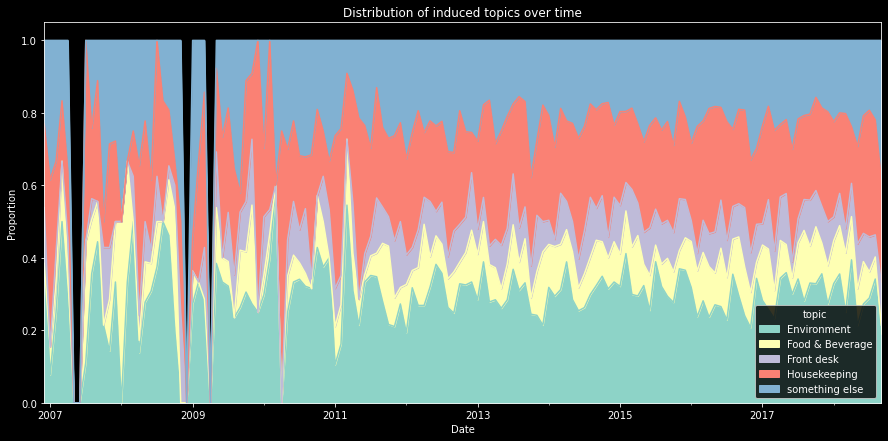

In [92]:
categories.plot(kind='area', title = 'Distribution of induced topics over time', ylabel = 'Proportion', xlabel = 'Date');

It seems the proportion holds through time. While is very noisy. Let's simplify it a bit by just checking the latest year.

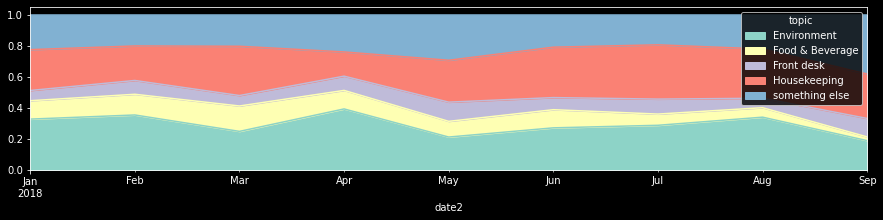

In [46]:
#categories.loc['2014':'2014',:].plot(kind='line',figsize=(12,3))
#categories.loc['2015':'2015',:].plot(kind='line',figsize=(12,3))
#categories.loc['2016':'2016',:].plot(kind='line',figsize=(12,3))
#categories.loc['2017':'2017',:].plot(kind='line',figsize=(12,3))
categories.loc['2018':'2018',:].plot(kind='area',figsize=(15,3));

It seems that something else is becoming more important in comments. But also Housekeeping. Probably should explore that content with other algorithms.

## Other way to classify reviews: LDA

I used word2vec to automatic classify sentences. But there are other options available. For instance, We could do some topic modelling. The standard algorithm is Latent Dirichlet Allocations or LDA, which will cluster sentences in a given number of topics. We have several ways to procced here. 

### Regular LDA

First we need to determinate the proper numer of topics. As this is a unsupervised technique, we can only use some heuristics. To do so, I will use perplexiy and coherence score.

In [185]:
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
np.random.seed(100)

common_dictionary = Dictionary(text)
common_corpus = [common_dictionary.doc2bow(i) for i in text]
# the model on the corpus.
lda = LdaModel(common_corpus, id2word = common_dictionary, num_topics = 20, random_state=1)

In [187]:
for i in range(99):
    lda = LdaModel(common_corpus, id2word = common_dictionary, num_topics = 20, random_state=i)
    cm_lda = CoherenceModel(model=lda, texts=text, dictionary=common_dictionary, coherence='c_v')
    print(i," : ", cm_lda.get_coherence())

0  :  0.33781800333152884
1  :  0.32164095093265616
2  :  0.35375951460210003
3  :  0.33738444665913186
4  :  0.3581292196806597
5  :  0.3595490428694443
6  :  0.3578963652396589
7  :  0.33836576302594595
8  :  0.31544628531857244
9  :  0.3450950211839981
10  :  0.36308454498440546
11  :  0.3387979347205832
12  :  0.3712196246824039
13  :  0.3584362335169578
14  :  0.34442780399060735
15  :  0.35492233520224625
16  :  0.3396138588487998
17  :  0.34671089443277436
18  :  0.35651170321530085
19  :  0.35566106813396814
20  :  0.3630202199639092
21  :  0.34768774150442855
22  :  0.3293097702334432
23  :  0.32156598782406254
24  :  0.3327563342305211
25  :  0.3417268226523409
26  :  0.3480977922775715
27  :  0.34830277731210735
28  :  0.35419484296434456
29  :  0.33404988601469054
30  :  0.3491729983290921
31  :  0.3362076074398636
32  :  0.38169741585349504
33  :  0.3455174195070764
34  :  0.3271796276076835
35  :  0.3427522035083351
36  :  0.35274642285541946
37  :  0.35790176791604666
38

In [171]:
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim_models.prepare(lda, common_corpus,common_dictionary, mds='tsne');
panel

c:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared 

PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
6      -10.878068   10.538728       1        1  9.621238
11     -60.884026  -75.591820       2        1  8.325191
1       -2.336119  -53.289074       3        1  6.624573
14     -61.385319  -12.914634       4        1  6.098490
19     -28.737743  126.296997       5        1  5.798717
16       1.066606 -123.552811       6        1  5.784443
8       45.140720   -7.947869       7        1  5.343734
9     -140.795975  -98.530548       8        1  5.022971
7       61.531681  -83.240562       9        1  4.995051
13     -72.563057 -140.396881      10        1  4.267321
5       15.984491   63.578186      11        1  4.171551
18    -160.851624   68.945145      12        1  4.021010
3       85.961830   51.922935      13        1  3.872496
15     -99.020836  109.936348      14        1  3.828982
12    -176.764130   -8.681684      15        1  3.821890
0     -117.189880  -37.420200      16        1  3.817586
2      108.829918  -22.946203      17        1  3.756899
10      47.588097  121.934814      18        1  3.673809
4     -106.467834   30.176889      19        1  3.582278
17     -50.613804   59.328842      20        1  3.571769, topic_info=             Term        Freq        Total Category  logprob  loglift
8          stayed  701.000000   701.000000  Default  30.0000  30.0000
31          staff  740.000000   740.000000  Default  29.0000  29.0000
259         would  614.000000   614.000000  Default  28.0000  28.0000
51     sea_temple  670.000000   670.000000  Default  27.0000  27.0000
48         nights  336.000000   336.000000  Default  26.0000  26.0000
..            ...         ...          ...      ...      ...      ...
24   port_douglas   25.452771   567.585484  Topic20  -4.6427   0.2275
114        around   22.524122   290.992039  Topic20  -4.7650   0.7734
121           spa   22.699533   563.027627  Topic20  -4.7572   0.1211
256     reception   19.139666   178.965193  Topic20  -4.9278   1.0967
59           room   19.568329  1159.585111  Topic20  -4.9056  -0.7498

[1295 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
176       1  0.021416  absolutely
176       2  0.085664  absolutely
176       3  0.074956  absolutely
176       5  0.010708  absolutely
176       7  0.064248  absolutely
...     ...       ...         ...
2205     14  0.851136         yet
2205     18  0.094571         yet
1788      7  0.881790          yo
1919     11  0.950507       young
1151     17  0.912222       yummy

[4010 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 12, 2, 15, 20, 17, 9, 10, 8, 14, 6, 19, 4, 16, 13, 1, 3, 11, 5, 18])

### Simple LDA evaluation

In [186]:
from gensim.models import CoherenceModel

cm_lda = CoherenceModel(model=lda, texts=text, dictionary=common_dictionary, coherence='c_v')
cm_lda.get_coherence()

0.32164095093265616

### Mallet implementation LDA

Ok, topics seems to be very well defined (no superpositions), but coherence is very low. Let's try something else like mallet LDA implementation.

In [173]:
import os
os.environ.update({'MALLET_HOME': '..\\mallet-2.0.8\\'})
mallet_path = '..\\mallet-2.0.8\\bin\\mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=common_corpus, num_topics=20, id2word=common_dictionary)

In [188]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3, seed = 100):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, random_state = seed)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values
limit=60; start=2; step=6;
model_list, coherence_values = compute_coherence_values(dictionary=common_dictionary, 
                                                        corpus=common_corpus, texts=text, 
                                                        start=start, limit=limit, step=step, seed = 12)

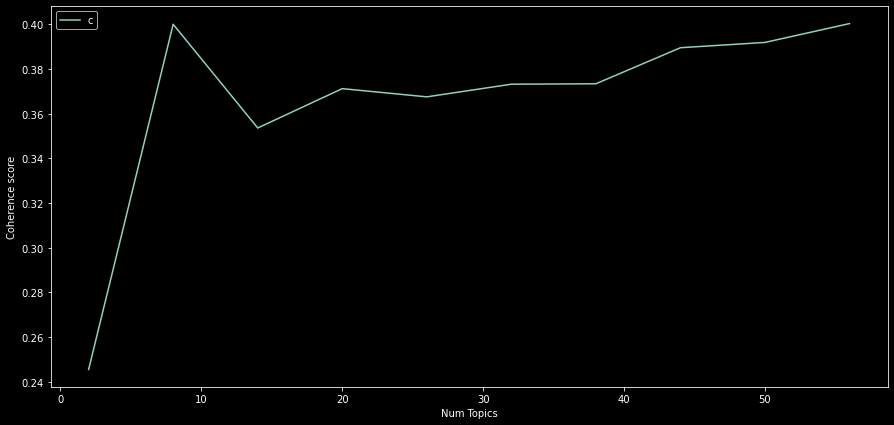

In [189]:
x = range(start, limit, step)
plt.pyplot.plot(x, coherence_values)
plt.pyplot.xlabel("Num Topics")
plt.pyplot.ylabel("Coherence score")
plt.pyplot.legend(("coherence_values"), loc='best')
plt.pyplot.show()

So now we have an improvement over previous implementation. With enough number of topics to be adecuate, good score without splitting too much.

In [192]:
print('Score with 20 topics: {0} \nMax Score with {1} topics: {2}'.format(coherence_values[3],x[np.argmax(coherence_values[:7])],max(coherence_values[:7])))

Score with 20 topics: 0.3712196246824039 
Max Score with 8 topics: 0.4000583232822574


In [195]:
pyLDAvis.gensim_models.prepare(model_list[1], common_corpus,common_dictionary, mds='tsne')

c:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared 

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3     -108.958252 -208.941483       1        1  16.948363
6      186.487061  -98.103249       2        1  14.775441
7       19.245832  160.858780       3        1  13.659637
1      170.658829   75.445076       4        1  12.913232
4       -1.386411  -35.043739       5        1  12.258070
2     -145.800095  106.944611       6        1  10.501705
5       64.834541 -221.825272       7        1  10.311421
0     -196.906036  -58.990913       8        1   8.632131, topic_info=           Term        Freq        Total Category  logprob  loglift
31        staff  707.000000   707.000000  Default  30.0000  30.0000
51   sea_temple  613.000000   613.000000  Default  29.0000  29.0000
8        stayed  664.000000   664.000000  Default  28.0000  28.0000
130    friendly  299.000000   299.000000  Default  27.0000  27.0000
48       nights  316.000000   316.000000  Default  26.0000  26.0000
..          ...         ...          ...      ...      ...      ...
259       would   46.005947   582.598452   Topic8  -4.9332  -0.0890
23        hotel   43.083516   611.821471   Topic8  -4.9988  -0.2036
164     however   31.586620   152.812465   Topic8  -5.3092   0.8732
213       place   32.834659   298.853713   Topic8  -5.2705   0.2412
59         room   30.933763  1107.542763   Topic8  -5.3301  -1.1284

[613 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
235       2  0.927730  accommodating
235       7  0.051541  accommodating
1309      2  0.969445          added
3135      7  0.945088       adjacent
447       2  0.916350      afternoon
...     ...       ...            ...
921       1  0.905530       year_old
605       5  0.895704            yes
605       6  0.083972            yes
2205      6  0.961429            yet
1919      6  0.984376          young

[1597 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 7, 8, 2, 5, 3, 6, 1])

Let's select the most representative topic to understand better its content

In [199]:
def topic2DF(ldamodel, corpus, text):
    """
    ldamodel: Gensim ldamodel
    corpus: List of
    text: list of keywords

    Return: Pandas DataFrame with most likely topic by text, the probability score of a text 
    to belong to that topic, topic keywords and original text, using a trained lda model.
    """
    topic_n_list, topic_prob_list, topic_kw_list = [], [] , []
    for row in ldamodel[corpus]:
        topic_num, prop_topic = max(row, key= lambda x: x[1])
        topic_n_list.append(topic_num)
        topic_prob_list.append(round(prop_topic, 4))

        wp = ldamodel.show_topic(topic_num)
        topic_kw_list.append(", ".join([word for word, prop in wp]))

    return pd.DataFrame({'Dominant_Topic':topic_n_list, 
    'Perc_Contribution': topic_prob_list, 'Topic_Keywords': topic_kw_list,
    'Content': text})

df_topic_sents_keywords = topic2DF(ldamodel = model_list[1], corpus=common_corpus, text=text)


In [200]:
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

topics_resume = df_dominant_topic.groupby(['Dominant_Topic','Keywords'], as_index=False)['Topic_Perc_Contrib'].agg(['max','idxmax']).reset_index()
topics_resume['Text'] = topics_resume['idxmax'].map(df_dominant_topic.Text)
topics_resume['Text'] = topics_resume.Text.apply(" ".join)
topics_resume = topics_resume[['Dominant_Topic', 'max', 'Keywords','idxmax', 'Text']]
topics_resume.columns = ['Topic_Num', 'Topic_Perc_Contrib', 'Keywords', 'idxmax','Text']
topics_resume = pd.merge(topics_resume, data_sentence,
    left_on="Text",
    right_on="sentence",
    how="left")

In [201]:
topics_resume[['Topic_Num', 'Topic_Perc_Contrib', 'Keywords', 'Text','title','topic']]   

,Topic_Num,Topic_Perc_Contrib,Keywords,Text,title,topic
0,0,0.9484,"beautiful, great, beach, resort, pool, walk, away, area, port_douglas, food",huge apartments great pool close beach lots area minutes drive main shopping area local supermarket handy,My preferred stay in Port Douglas,Environment
1,1,0.9512,"apartment, one, sea_temple, spa, bedroom, booked, port_douglas, two, stayed, room",shuttle convenient amount days pass consecutive use much want day decide skip days till need call pick,This place was perfect for us.,Environment
2,2,0.9560,"time, day, back, go, breakfast, us, room, would, hotel, even",waited almost mins served check even though staff free counter redirected continue waiting together groups people also waiting check,Don't be fooled!,Front desk
3,3,0.9450,"stayed, sea_temple, stay, nights, great, resort, port_douglas, pool, would, room",breakfast good quality offering every day particularly remarkable feature apart popular nespresso type coffee machine,A Really Relaxing and Comfortable Stay,Environment
4,4,0.9538,"hotel, town, pool, service, resort, would, us, room, get, little",discussion conference manager provided could expect busy conferences total attendees less people many given size resort dismissive comments,Inflexible and Dismissive,Front desk
5,5,0.9562,"kitchen, apartment, rooms, bedroom, penthouse, spa, pool, area, bbq, rooftop",generous sized deck huge upper deck spa barbecue facilities perhaps needed plants art make little nicer bare large area,Honeymoon,Housekeeping
6,6,0.9507,"staff, pool, friendly, resort, helpful, fantastic, lovely, room, great, service",caused much angst holiday tasks would straight fwd normal course became impossible protracted took away family time,What a shame,Housekeeping
7,7,0.9503,"pool, room, spa, large, bed, clean, lagoon, huge, swim, well",one evening hotel looked like corporate event right lobby pool one literally walk event get front lobby,"Tired, Overpriced, and Too far from Town",Environment


In [59]:
#display(HTML(topics_resume[["Text",'comment']].apply(highlight_selected_text, **{'col_keywords':'Text'}, axis=1).to_frame().to_html(escape=False)))
#df_dominant_topic[(df_dominant_topic.Dominant_Topic == 4) & (df_dominant_topic.Text.str.len() > 5) & (df_dominant_topic.Topic_Perc_Contrib > 0.6)].Text.apply(" ".join)

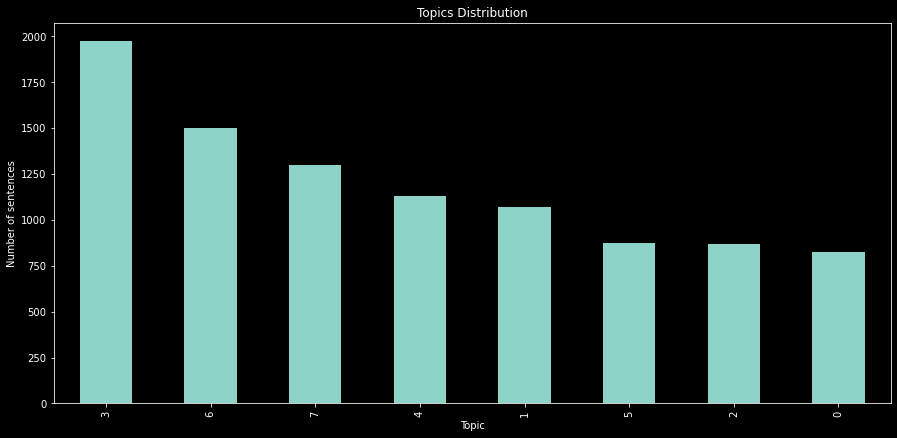

In [202]:
df_dominant_topic.Dominant_Topic.value_counts().plot(kind= 'bar',title='Topics Distribution', xlabel='Topic', ylabel="Number of sentences");

Now can we have a look to the content of the topics. We can even interpret them as follows:

|Topic # | Interpretation | Personal insight |
|---|---|---|
|0| Staff | |
|1| Common Infrastructure |  |
|2| Overall Experience | |
|3| Hotel Rooms vs Private owned rooms | Interestintly, some rooms are privatly owned and managed. Normally booked in AirBnB without including some of the resort's servicesas housekeeping. Some people realise of these upon arrival |
|4| --- not good topic --- | Less common topic |
|5| Housekeeping | |
|6| Infrastructure vs service | |
|7| Location in Port Douglas | |
|8| Distance to The Town | As comment before, th Restort is far away from town and there is no public transport in Port Douglas. But at the same time most rooms include kitchen |
|9| Restaurant | |
|10| Bad experiences |
|11| Moving around resort | Resort is more like a neighbourhood, a lot of walking between restaurant and rooms |
|12| Restaurant | |
|13| Swiming pool | |
|14| Room services and expectations | |
|15| Family resort | During school holidays the places is full of toddlers that may ruin your experience |
|16| Rooms with terrace | |
|17| Villas- Penhouse | |
|18| Short trip experience | |
|19| Rooms | |

#### Topic throught time

In [203]:
df_dominant_topic['date'] = data_sentence.date2
topic_time = df_dominant_topic.set_index(pd.DatetimeIndex(df_dominant_topic['date']))
topic_time = topic_time.sort_index()

topic_time = pd.crosstab(topic_time.date, topic_time.Dominant_Topic)
topic_time = topic_time.resample(rule='M').mean()

topic_time['total'] = topic_time.sum(axis=1)
topic_time = topic_time.div(topic_time.total,0)
topic_time = topic_time.drop('total',axis=1);
#topic_time.head()

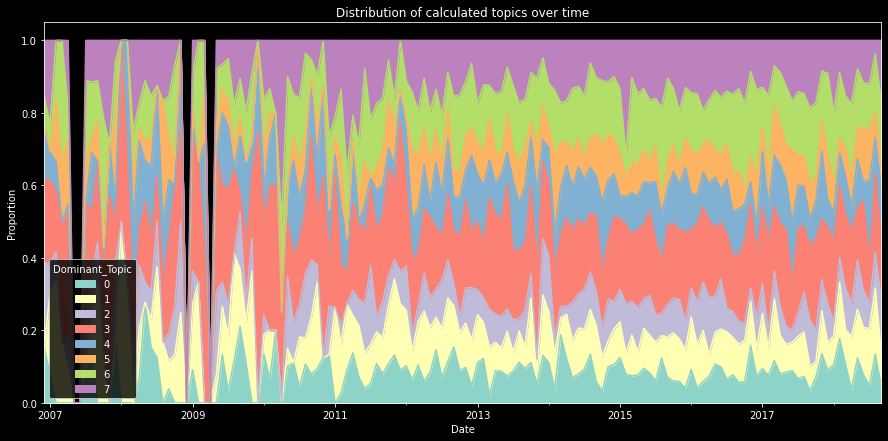

In [204]:
topic_time.plot(kind='area', title = 'Distribution of calculated topics over time', ylabel = 'Proportion', xlabel = 'Date');

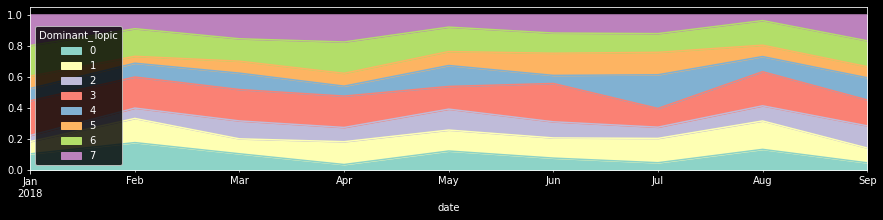

In [205]:
topic_time.loc['2018':'2018',:].plot(kind='area',figsize=(15,3));

# Sentiment analysis

So far I have seen how frequently each section got named, but I don't have idea if it is positive or negative. As most reviews give a high score to the resort we could asumme that most comments are positive, but its not necessary. To do these we could use pre-build polarity sentiment models.

In [82]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def nltk_sentiment(sentence):
    nltk_sentiment = SentimentIntensityAnalyzer()
    score = nltk_sentiment.polarity_scores(sentence)
    return score

In [83]:
nltk_results = data_sentence.sentence.apply(nltk_sentiment)
results_df = pd.DataFrame(nltk_results.tolist())
#text_df = pd.DataFrame(dataset, columns = ['text'])
data_sentiment = data_sentence.join(results_df)

data_sentiment.set_index(pd.DatetimeIndex(data_sentiment['date2']), inplace=True)
data_sentiment = data_sentiment.sort_index()

### Global sentiment by category

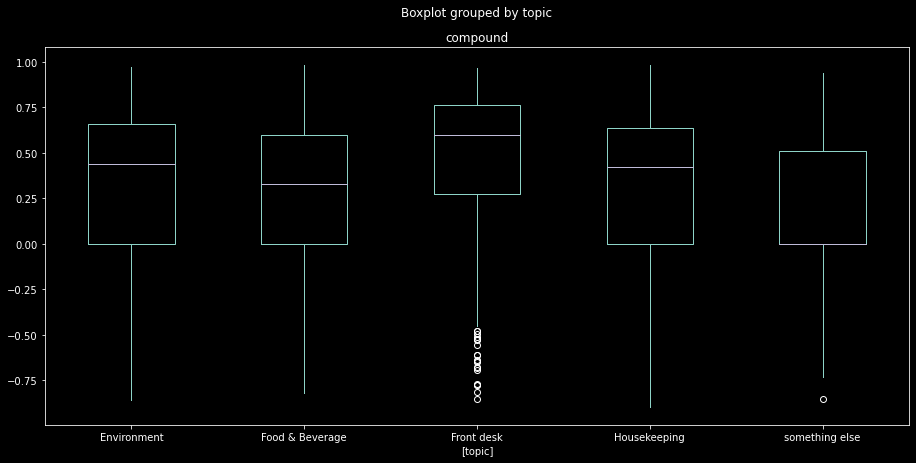

In [84]:
data_sentiment[['topic', 'compound']].boxplot(by='topic',grid=False);

### Sentiment by time and category

In [85]:
sen = pd.pivot_table(data_sentiment, values='compound', index=data_sentiment.index, columns=['topic'], aggfunc=np.mean)
sen = sen.resample(rule='M').mean()

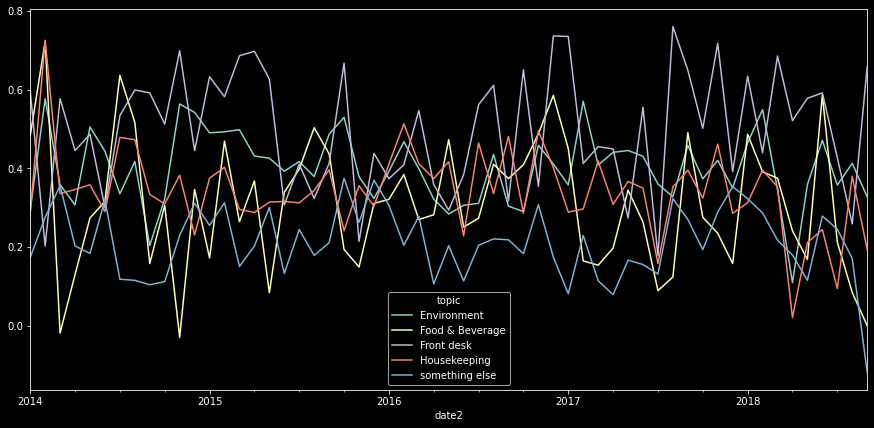

In [86]:
sen[sen.index>pd.to_datetime("31/12/2013", format= "%d/%m/%Y")].plot(kind='line');

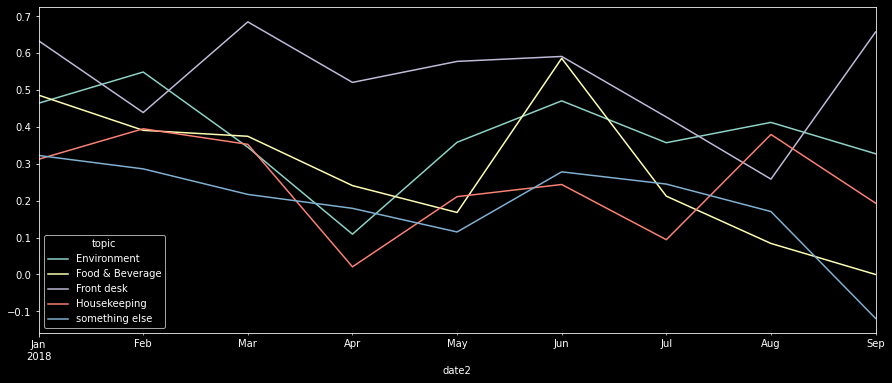

In [88]:
#sen.loc['2014':'2014',:].plot(kind='line', figsize=(12,3))
#sen.loc['2015':'2015',:].plot(kind='line', figsize=(12,3),legend=False)
#sen.loc['2016':'2016',:].plot(kind='line', figsize=(12,3))
#sen.loc['2017':'2017',:].plot(kind='line', figsize=(12,3),legend=False)
sen.loc['2018':'2018',:].plot(kind='line', figsize=(15,6));

Positive sentiments are more likely for every aspect but the most important takeaway here is variation. Both graphs show a lot of noise. Let's clear it out a bit.

### Seasonal Decomposition

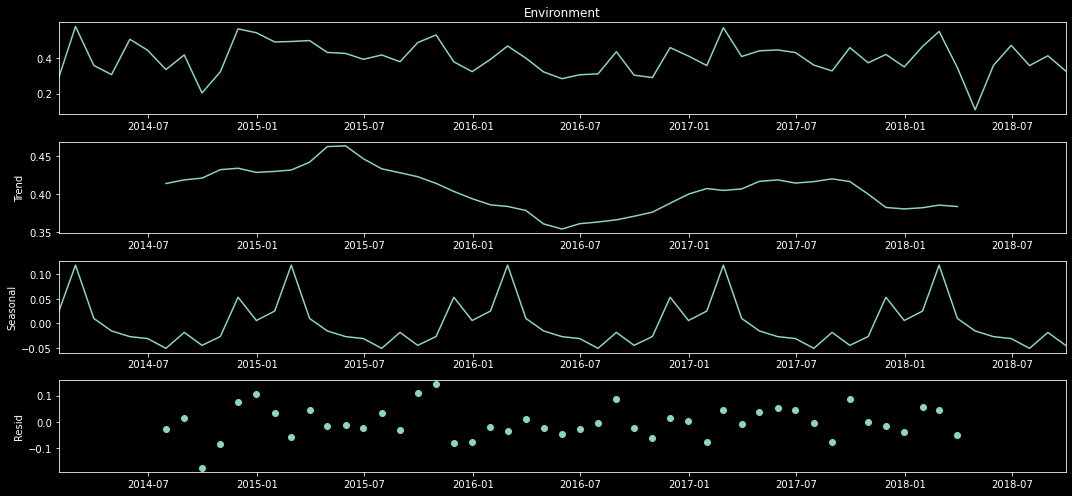

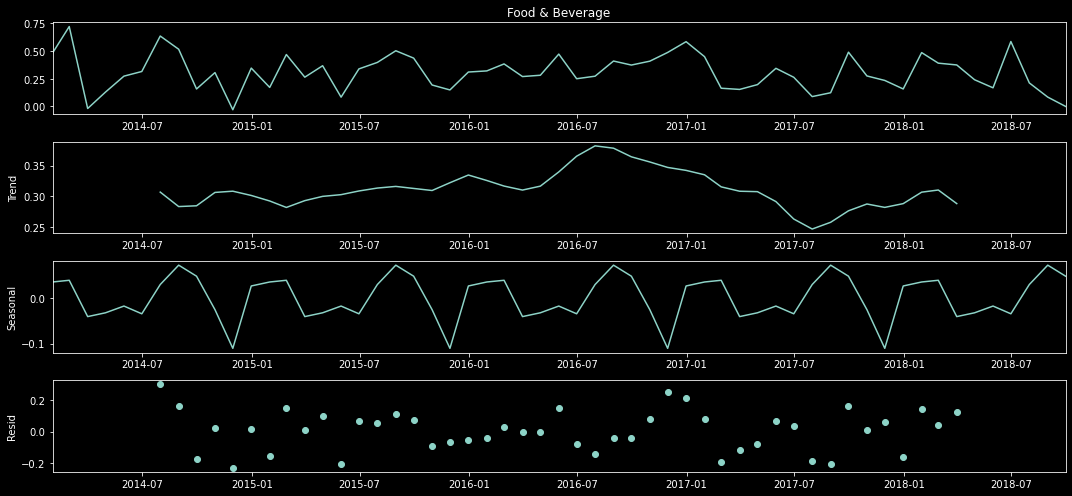

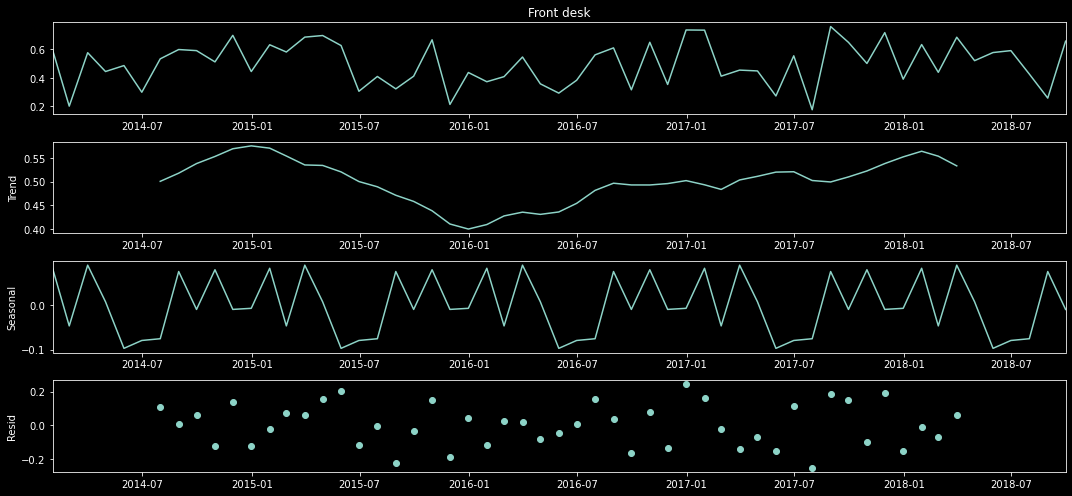

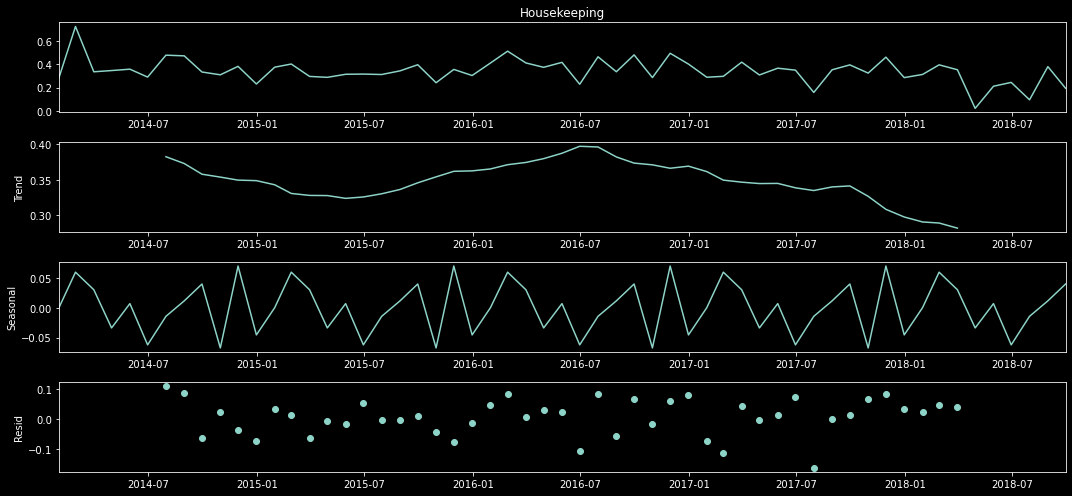

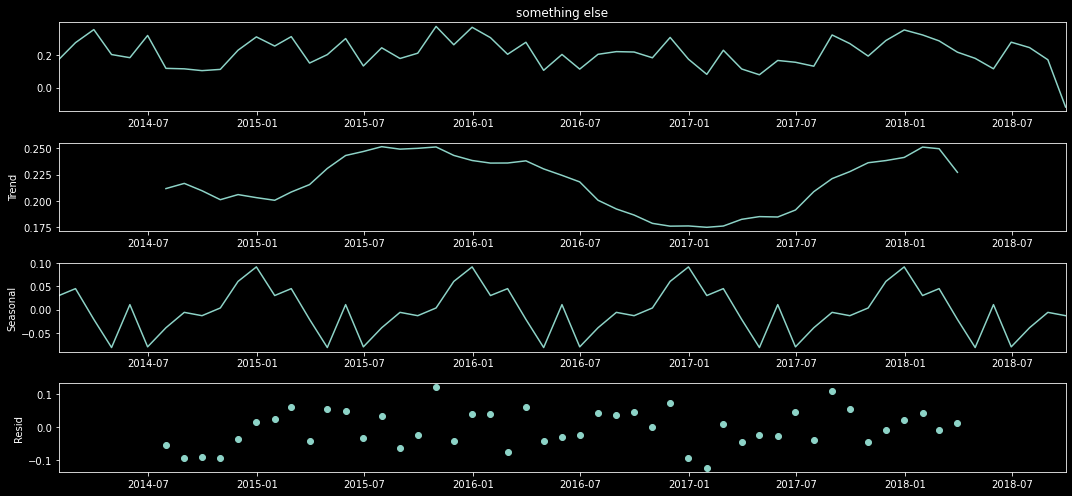

In [89]:
from statsmodels.tsa.seasonal import seasonal_decompose
serie = sen[sen.index>pd.to_datetime("31/12/2013", format= "%d/%m/%Y")]
for i in sen.columns:
    result = seasonal_decompose(serie[i], model='additive')
    result.plot()


OK, this looks interesting. Sentiment are seasonal and doesn't show a trend. Except for "Enviroment," which is becoming more and more negative. It kind of makes sense that Enviromnent get lower score over time as infraestructure becomes old and regular customers get used to, for instance, the pool. It doesn't plays an important part of their experience any more.

In the other hand, housekeeping is very seasonal (very positive at the begining of the year, flat the rest of the year.

## Validation

Finally, we can validate these results by comparing them to the scores given by the user next to the comments

In [231]:
data_sentence.columns

Index(['sentence', 'title', 'score', 'comment', 'date', 'new_col', 'keywords',
       'topic', 'probability', 'date2'],
      dtype='object')

In [235]:
data_sentence[['score', 'topic', 'sentence', 'comment']]

,score,topic,sentence,comment
0,3.0,something else,star prices star service,5 star prices and 3 star service. We stayed in a villa with a private pool which was ok but needs updating and looks tired. The maintenance man even said it’s so hard to keep up with all the hotels issues. The food is bang average not just at the hotel but all round port Douglas. The staff are all great and try and make your stay nice it’s not their fault I just think this is how the hotel is run. 3 stars
1,3.0,Housekeeping,stayed villa private pool ok needs updating looks tired,5 star prices and 3 star service. We stayed in a villa with a private pool which was ok but needs updating and looks tired. The maintenance man even said it’s so hard to keep up with all the hotels issues. The food is bang average not just at the hotel but all round port Douglas. The staff are all great and try and make your stay nice it’s not their fault I just think this is how the hotel is run. 3 stars
2,3.0,Environment,maintenance man even said hard keep hotels issues,5 star prices and 3 star service. We stayed in a villa with a private pool which was ok but needs updating and looks tired. The maintenance man even said it’s so hard to keep up with all the hotels issues. The food is bang average not just at the hotel but all round port Douglas. The staff are all great and try and make your stay nice it’s not their fault I just think this is how the hotel is run. 3 stars
3,3.0,something else,food bang average hotel round port_douglas,5 star prices and 3 star service. We stayed in a villa with a private pool which was ok but needs updating and looks tired. The maintenance man even said it’s so hard to keep up with all the hotels issues. The food is bang average not just at the hotel but all round port Douglas. The staff are all great and try and make your stay nice it’s not their fault I just think this is how the hotel is run. 3 stars
4,3.0,Housekeeping,staff great try make stay nice fault think hotel run,5 star prices and 3 star service. We stayed in a villa with a private pool which was ok but needs updating and looks tired. The maintenance man even said it’s so hard to keep up with all the hotels issues. The food is bang average not just at the hotel but all round port Douglas. The staff are all great and try and make your stay nice it’s not their fault I just think this is how the hotel is run. 3 stars
...,...,...,...,...
9531,4.0,something else,manager told yes know worth get,"This is a great resort if you like luxurious living. The rooms were nice (and we only got a studio), very comfortable bed, awesome jacuzzi bathtub and great pool. Service was surprisingly good, since we'd heard some bad things prior to coming. Very accomodating staff. You also get your own little garage for your car. The negatives, they provide robes which is like putting sandpaper to your skin, there are sugar ants that may invade your room in the summer (which they do give you spray for if you get them - we had them just one night). Limited menu if you're a vegetarian (so just go into ""town"") and lastly, this place is in the middle of NO WHERE. Off the main street, there's one sign to turn and then no others... we found the golf club and had to go ask where to go from there... they do not make it easy to find. (The manager told me ""Yes, I know, but it's worth it once you get there."" hmmmm.) All in all a great value for the $$$ - we'd go back."
9532,4.0,something else,hmmmm,"This is a great resort if you like luxurious living. The rooms were nice (and we only got a studio), very comfortable bed, awesome jacuzzi bathtub and great pool. Service was surprisingly good, since we'd heard some bad things prior to coming. Very accomodating staff. You also get your own little garage for your car. The negatives, they provide robes which is like putting sandpaper to your skin, there are sugar ants that may invade your room in the summer (which they do give you spray for if you get them - we had them just

## Conclusions

We can summarise the main take away as:

- Seasonality put crate pressure over both Food and beverage and Housekeeping
- It is important to considere that one of the most important features of the PPD is the swiming pool and other enviromental and infrastructure factors, and those may need renewal

There are many more thing that can be done with this dataset. we could go deeper with the topics and try to identify subtopics. Create a regression to identifyt factors affecting the overall score